Import necessary libraries

In [ ]:
import pandas as pd
import numpy as pandas
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [11]:
dataset=pd.read_csv('nike_shoes_sales.csv',encoding='latin-1')

In [12]:
dataset.columns

Index(['product_name', 'product_id', 'listing_price', 'sale_price', 'discount',
       'brand', 'description', 'rating', 'reviews', 'images'],
      dtype='object')

In [13]:
dataset.describe()

,listing_price,sale_price,discount,rating,reviews
count,643.000000,643.000000,643.0,643.000000,643.000000
mean,3875.762053,10213.676516,0.0,2.734837,7.181960
std,5889.947172,4513.289512,0.0,2.137756,15.968315
min,0.000000,1595.000000,0.0,0.000000,0.000000
25%,0.000000,6995.000000,0.0,0.000000,0.000000
50%,0.000000,9597.000000,0.0,3.800000,1.000000
75%,8495.000000,12797.000000,0.0,4.600000,6.000000
max,19995.000000,36500.000000,0.0,5.000000,223.000000


In [14]:
#Drop discount column as it is constant and all 0 and also images as we won't be using them
dataset.drop(['discount', 'images'], axis=1, inplace=True)

In [15]:
dataset.isnull().sum()

product_name     0
product_id       0
listing_price    0
sale_price       0
brand            0
description      3
rating           0
reviews          0
dtype: int64

In [16]:
dataset['description'].fillna('',inplace=True)

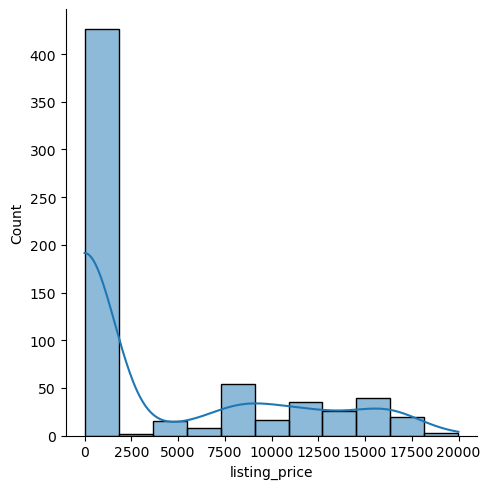

In [17]:
sns.displot(data=dataset,x='listing_price',kde=True)

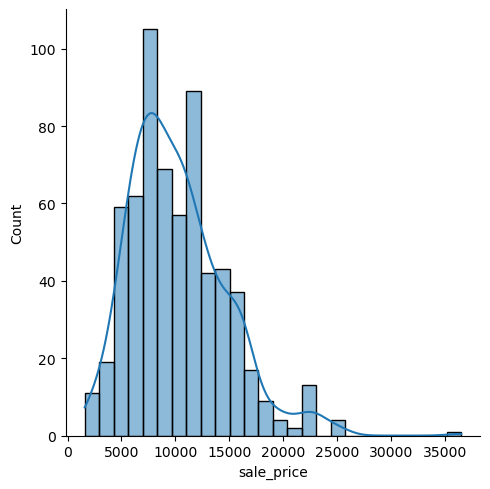

In [18]:
sns.displot(data=dataset,x='sale_price',kde=True)

Convert to $ as sales numbers are not reflecting the true values

In [19]:
dataset['sale_price'] = dataset['sale_price'] / 100
dataset['listing_price'] = dataset['listing_price'] / 100

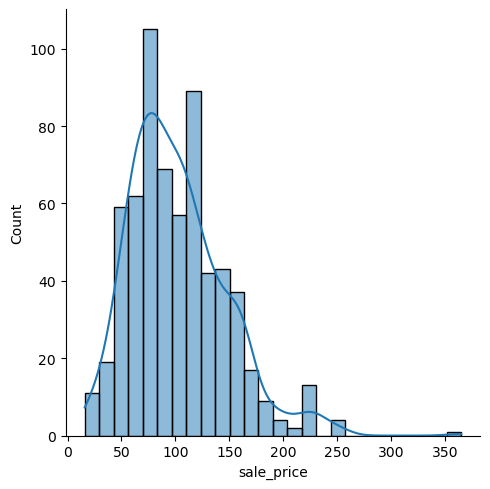

In [20]:
sns.displot(data=dataset,x='sale_price',kde=True)

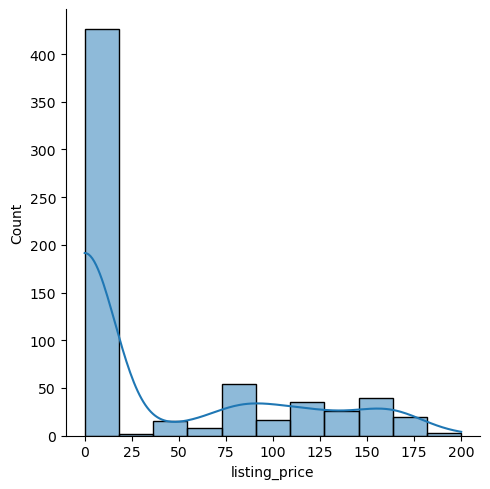

In [21]:
sns.displot(data=dataset,x='listing_price',kde=True)

In [22]:
dataset

,product_name,product_id,listing_price,sale_price,brand,description,rating,reviews
0,Nike Air Force 1 '07 Essential,CJ1646-600,0.00,74.95,Nike,Let your shoe game shimmer in the Nike Air For...,0.0,0
1,Nike Air Force 1 '07,CT4328-101,0.00,74.95,Nike,The legend lives on in the Nike Air Force 1 '0...,0.0,0
2,Nike Air Force 1 Sage Low LX,CI3482-200,0.00,99.95,Nike,"Taking both height and craft to new levels, th...",0.0,0
3,Nike Air Max Dia SE,CD0479-200,0.00,99.95,Nike,"Designed for a woman's foot, the Nike Air Max ...",0.0,0
4,Nike Air Max Verona,CZ6156-101,0.00,99.95,Nike,Pass on the good vibes in the Nike Air Max Ver...,0.0,0
...,...,...,...,...,...,...,...,...
638,Air Jordan 8 Retro,CI1236-100,159.95,127.97,Nike,The Air Jordan 8 Retro recaptures the memorabl...,5.0,1
639,Nike Phantom Venom Club IC,AO0578-717,49.95,34.97,Nike,The Nike Phantom Venom Club IC is engineered f...,0.0,0
640,Nike Mercurial Superfly 7 Academy TF,AT7978-414,84.95,59.47,Nike,The soft upper of the Nike Mercurial Superfly ...,5.0,1
641,Nike Air Max 98,AH6799-300,0.00,169.95,Nike,The Nike Air Max 98 features the OG design lin...,4.0,4


For each product with a listing_price of zero, we'll find a similar product based on the product name. Then, we'll impute the listing_price of our target product with the sale_price of the most similar product.

In [23]:
# 1. Vectorize product names using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(dataset['product_name'])

# Function to get the index of the most similar product
def get_similar_product(idx):
    cosine_similarities = linear_kernel(tfidf_matrix[idx], tfidf_matrix).flatten()
    # We ignore the product itself by setting its similarity to -1
    cosine_similarities[idx] = -1
    return cosine_similarities.argmax()

# 2. For each product with a listing_price of zero, find the most similar product
zero_price_indices = dataset[dataset['listing_price'] == 0].index

for idx in zero_price_indices:
    similar_idx = get_similar_product(idx)
    # Impute with the sale_price of the most similar product
    dataset.at[idx, 'listing_price'] = dataset.at[similar_idx, 'sale_price']

In [24]:
dataset

,product_name,product_id,listing_price,sale_price,brand,description,rating,reviews
0,Nike Air Force 1 '07 Essential,CJ1646-600,55.97,74.95,Nike,Let your shoe game shimmer in the Nike Air For...,0.0,0
1,Nike Air Force 1 '07,CT4328-101,74.95,74.95,Nike,The legend lives on in the Nike Air Force 1 '0...,0.0,0
2,Nike Air Force 1 Sage Low LX,CI3482-200,89.95,99.95,Nike,"Taking both height and craft to new levels, th...",0.0,0
3,Nike Air Max Dia SE,CD0479-200,59.97,99.95,Nike,"Designed for a woman's foot, the Nike Air Max ...",0.0,0
4,Nike Air Max Verona,CZ6156-101,99.95,99.95,Nike,Pass on the good vibes in the Nike Air Max Ver...,0.0,0
...,...,...,...,...,...,...,...,...
638,Air Jordan 8 Retro,CI1236-100,159.95,127.97,Nike,The Air Jordan 8 Retro recaptures the memorabl...,5.0,1
639,Nike Phantom Venom Club IC,AO0578-717,49.95,34.97,Nike,The Nike Phantom Venom Club IC is engineered f...,0.0,0
640,Nike Mercurial Superfly 7 Academy TF,AT7978-414,84.95,59.47,Nike,The soft upper of the Nike Mercurial Superfly ...,5.0,1
641,Nike Air Max 98,AH6799-300,169.95,169.95,Nike,The Nike Air Max 98 features the OG design lin...,4.0,4


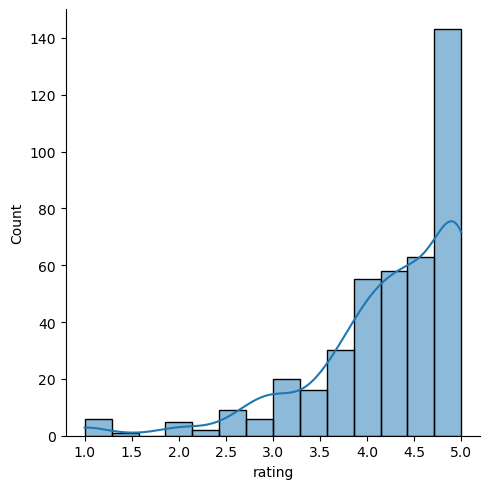

In [25]:
#Exclude 0 ratings as it means there are no current ratings for that product
sns.displot(data=dataset[dataset["rating"] != 0], x="rating", kde=True)

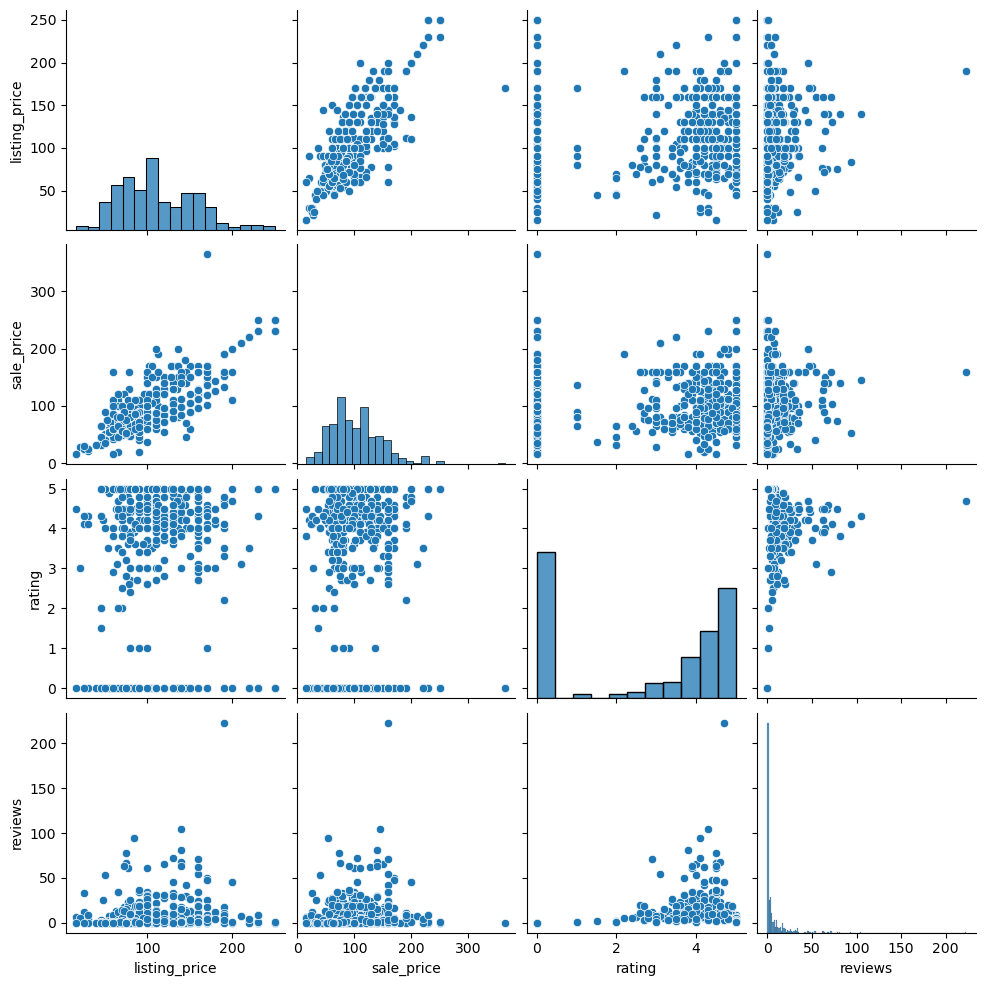

In [26]:
sns.pairplot(dataset)

In [27]:
dataset['price_difference'] = dataset['listing_price'] - dataset['sale_price']

If we consider listing_price as the original or recommended retail price of the product and sale_price as the price at which it's actually being sold: then

Listing Price > Sale Price indicates product is being sold at a discount i.e. clear out old inventory, compute with other sellers

Listing Price < Sale Price indicates if demand is high, prices might surge above the original listing price. could be part of collector's item dynamic pricing

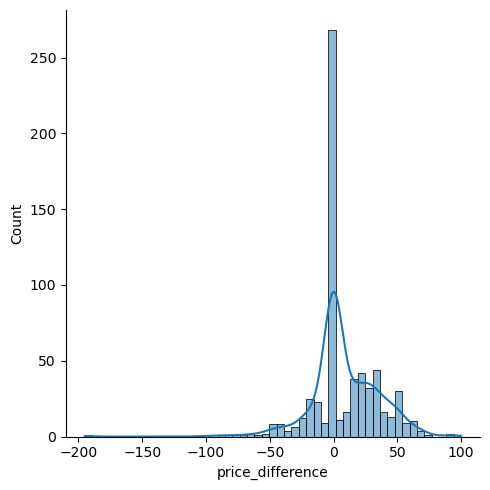

In [28]:
sns.displot(data=dataset, x="price_difference", kde=True)

In [29]:
dataset['price_ratio'] = dataset['sale_price'] / dataset['listing_price']

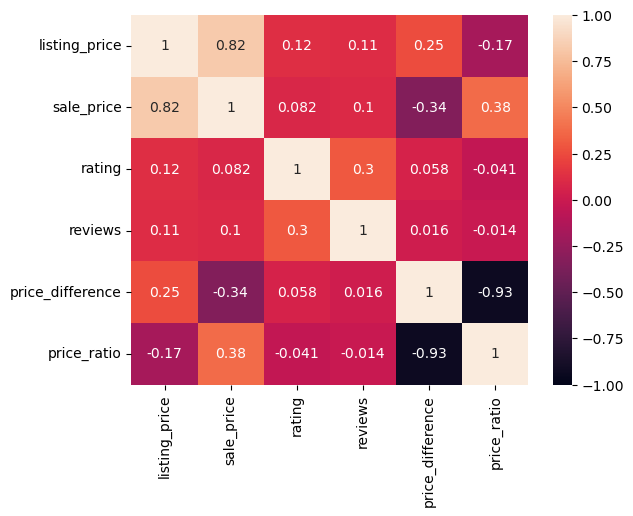

In [30]:
sns.heatmap(dataset.corr(), vmin=-1, vmax=1, annot=True);

In [31]:
#  price_ratio
dataset['price_ratio'] = dataset['sale_price'] / dataset['listing_price']

# price_category
quantiles = dataset['sale_price'].quantile([0.33, 0.66]).values
dataset['price_category'] = pd.cut(dataset['sale_price'], 
                              bins=[0] + list(quantiles) + [float('inf')], 
                              labels=['low', 'medium', 'high'])

dataset[['price_ratio', 'price_category']].head()

,price_ratio,price_category
0,1.339110,low
1,1.000000,low
2,1.111173,medium
3,1.666667,medium
4,1.000000,medium


In [32]:
dataset.head(5)

,product_name,product_id,listing_price,sale_price,brand,description,rating,reviews,price_difference,price_ratio,price_category
0,Nike Air Force 1 '07 Essential,CJ1646-600,55.97,74.95,Nike,Let your shoe game shimmer in the Nike Air For...,0.0,0,-18.98,1.339110,low
1,Nike Air Force 1 '07,CT4328-101,74.95,74.95,Nike,The legend lives on in the Nike Air Force 1 '0...,0.0,0,0.00,1.000000,low
2,Nike Air Force 1 Sage Low LX,CI3482-200,89.95,99.95,Nike,"Taking both height and craft to new levels, th...",0.0,0,-10.00,1.111173,medium
3,Nike Air Max Dia SE,CD0479-200,59.97,99.95,Nike,"Designed for a woman's foot, the Nike Air Max ...",0.0,0,-39.98,1.666667,medium
4,Nike Air Max Verona,CZ6156-101,99.95,99.95,Nike,Pass on the good vibes in the Nike Air Max Ver...,0.0,0,0.00,1.000000,medium


In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643 entries, 0 to 642
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   product_name      643 non-null    object  
 1   product_id        643 non-null    object  
 2   listing_price     643 non-null    float64 
 3   sale_price        643 non-null    float64 
 4   brand             643 non-null    object  
 5   description       643 non-null    object  
 6   rating            643 non-null    float64 
 7   reviews           643 non-null    int64   
 8   price_difference  643 non-null    float64 
 9   price_ratio       643 non-null    float64 
 10  price_category    643 non-null    category
dtypes: category(1), float64(5), int64(1), object(4)
memory usage: 51.1+ KB


In [34]:
label_encoder = LabelEncoder()
# Convert 'price_category' to numeric using label encoding
dataset['price_category_encoded'] = label_encoder.fit_transform(dataset['price_category'])
# Standardizing the data
features = ['listing_price', 'sale_price', 'rating', 'reviews', 'price_difference', 'price_ratio', 'price_category_encoded']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset[features])
# Hierarchical Clustering
linked = linkage(scaled_data, 'ward')

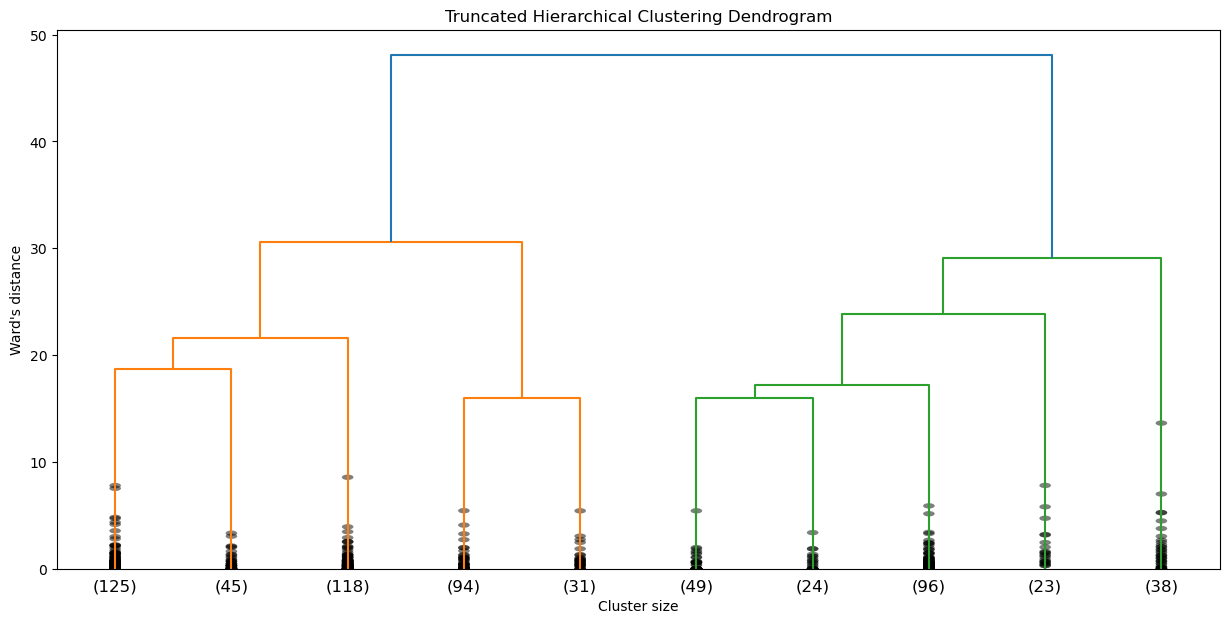

In [35]:
# Visualization: Dendrogram with Truncation
plt.figure(figsize=(15, 7))
dendrogram(linked,
           truncate_mode='lastp',  # Show only the last 'p' merged clusters
           p=10,  # Show only the last 10 merged clusters
           show_contracted=True,  # To give a summarized view
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title("Truncated Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster size")
plt.ylabel("Ward's distance")
plt.show()

In [36]:
scaled_dataset = pd.DataFrame(scaled_data, columns=features)
for col in dataset.columns:
    if col not in features:
        scaled_dataset[col] = dataset[col]

In [37]:
scaled_dataset 

,listing_price,sale_price,rating,reviews,price_difference,price_ratio,price_category_encoded,product_name,product_id,brand,description,price_category
0,-1.250013,-0.602840,-1.280299,-0.450113,-1.037481,1.567450,-0.028505,Nike Air Force 1 '07 Essential,CJ1646-600,Nike,Let your shoe game shimmer in the Nike Air For...,low
1,-0.816728,-0.602840,-1.280299,-0.450113,-0.323246,0.235658,-0.028505,Nike Air Force 1 '07,CT4328-101,Nike,The legend lives on in the Nike Air Force 1 '0...,low
2,-0.474300,-0.048489,-1.280299,-0.450113,-0.699555,0.672268,1.193416,Nike Air Force 1 Sage Low LX,CI3482-200,Nike,"Taking both height and craft to new levels, th...",medium
3,-1.158699,-0.048489,-1.280299,-0.450113,-1.827730,2.853867,1.193416,Nike Air Max Dia SE,CD0479-200,Nike,"Designed for a woman's foot, the Nike Air Max ...",medium
4,-0.246015,-0.048489,-1.280299,-0.450113,-0.323246,0.235658,1.193416,Nike Air Max Verona,CZ6156-101,Nike,Pass on the good vibes in the Nike Air Max Ver...,medium
...,...,...,...,...,...,...,...,...,...,...,...,...
638,1.123695,0.572827,1.060424,-0.387441,0.880191,-0.549560,-1.250426,Air Jordan 8 Retro,CI1236-100,Nike,The Air Jordan 8 Retro recaptures the memorabl...,high
639,-1.387441,-1.489358,-1.280299,-0.450113,0.240465,-0.942143,-0.028505,Nike Phantom Venom Club IC,AO0578-717,Nike,The Nike Phantom Venom Club IC is engineered f...,low
640,-0.588443,-0.946094,1.060424,-0.387441,0.635590,-0.942305,-0.028505,Nike Mercurial Superfly 7 Academy TF,AT7978-414,Nike,The soft upper of the Nike Mercurial Superfly ...,low
641,1.351980,1.503693,0.592279,-0.199422,-0.323246,0.235658,-1.250426,Nike Air Max 98,AH6799-300,Nike,The Nike Air Max 98 features the OG design lin...,high


In [38]:
# 6 clusters at Ward's distance 20
cluster = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
dataset['cluster_labels'] = cluster.fit_predict(scaled_dataset[features])

In [39]:
dataset[dataset["cluster_labels"] == 1]

,product_name,product_id,listing_price,sale_price,brand,description,rating,reviews,price_difference,price_ratio,price_category,price_category_encoded,cluster_labels
8,Nike Zoom Pegasus Turbo 2,AT8242-009,159.95,159.95,Nike,The Nike Zoom Pegasus Turbo 2 is updated with ...,2.7,14,0.00,1.000000,high,0,1
9,Nike Air Max 270 React ENG,CK2595-500,149.95,149.95,Nike,The Nike Air Max 270 React ENG combines a full...,5.0,2,0.00,1.000000,high,0,1
16,Nike Air Max 270 React ENG,CK2608-100,149.95,149.95,Nike,Refresh your step in the Nike Air Max 270 Reac...,0.0,0,0.00,1.000000,high,0,1
17,Nike Air Max 97,921733-104,159.95,169.95,Nike,The Nike Air Max 97 keeps a sneaker icon going...,4.3,16,-10.00,1.062520,high,0,1
20,Nike Air Max 97,CT4525-001,169.95,159.95,Nike,Remastered from the OG that shook up the runni...,0.0,0,10.00,0.941159,high,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,Nike Metcon 5 AMP,CN5455-160,119.95,119.95,Nike,The Nike Metcon 5 AMP arms you with stability ...,4.5,2,0.00,1.000000,high,0,1
632,Air Jordan 5 Retro,CD2722-001,189.95,159.95,Nike,The Air Jordan 5 Retro for women gives a colou...,3.3,3,30.00,0.842064,high,0,1
637,Nike React Metcon AMP,CT9155-063,139.95,139.95,Nike,The Nike React Metcon AMP takes the stability ...,3.0,1,0.00,1.000000,high,0,1
638,Air Jordan 8 Retro,CI1236-100,159.95,127.97,Nike,The Air Jordan 8 Retro recaptures the memorabl...,5.0,1,31.98,0.800063,high,0,1


In [ ]:
from sklearn.cluster import KMeans

# Using the Elbow method to find the optimal number of clusters
wcss = [] 
for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
    
# Plot the Elbow method
plt.plot(range(1, 16), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [41]:
# Apply KMeans clustering
optimal_clusters = 10 
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
dataset['kmeans_cluster_labels'] = kmeans.fit_predict(scaled_data)

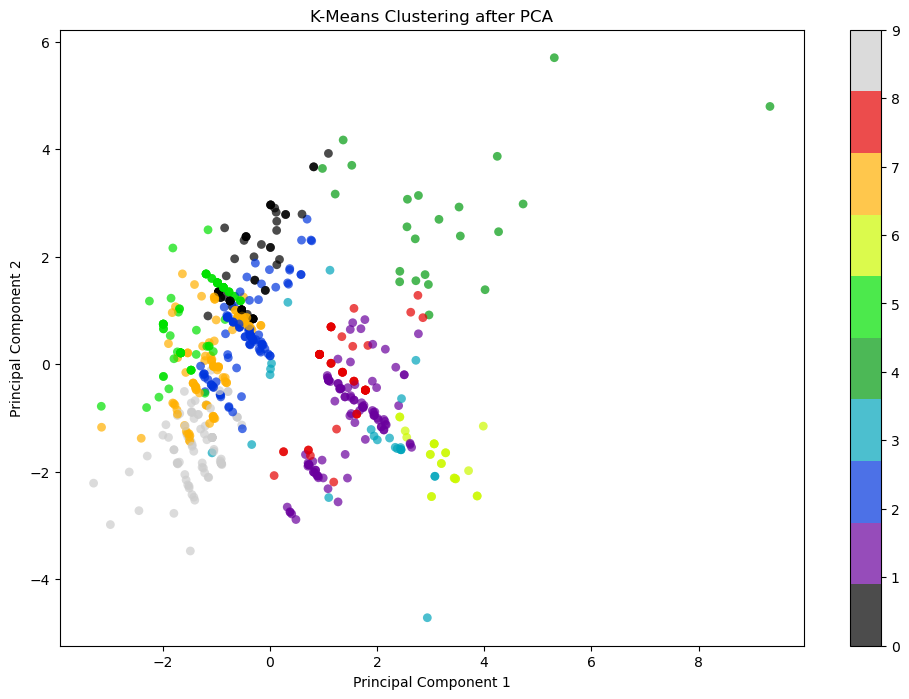

In [42]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_data)

plt.figure(figsize=(12, 8))
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=dataset['kmeans_cluster_labels'], edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('K-Means Clustering after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [43]:
dataset.product_name.value_counts()

Nike Air Max 90                         14
Nike Air Max 270 React                   9
Nike Air Max 97                          7
Nike Air Zoom Pegasus 36                 6
Nike Air VaporMax 360                    5
                                        ..
Zoom Freak 1 'Employee of the Month'     1
Zoom LeBron 3 QS                         1
Nike SB Check                            1
Nike Blazer Low                          1
Nike P-6000 SE                           1
Name: product_name, Length: 393, dtype: int64

In [44]:
productnames=dataset.product_name.value_counts().index

In [45]:
dataset.product_name.value_counts().index

Index(['Nike Air Max 90', 'Nike Air Max 270 React', 'Nike Air Max 97',
       'Nike Air Zoom Pegasus 36', 'Nike Air VaporMax 360', 'Nike Air Max 720',
       'Nike MX-720-818', 'Nike Air Max 2090', 'Nike Metcon 5 AMP',
       'Nike Zoom Pegasus Turbo 2',
       ...
       'Nike ISPA Joyride Envelope', 'Nike Zoom Vomero 5 SE SP',
       'Nike Benassi JDI', 'Jordan React Havoc SE',
       'Nike React Presto Premium', 'Zoom Freak 1 'Employee of the Month'',
       'Zoom LeBron 3 QS', 'Nike SB Check', 'Nike Blazer Low',
       'Nike P-6000 SE'],
      dtype='object', length=393)

In [46]:
productvalue=dataset.product_name.value_counts().values

([<matplotlib.patches.Wedge at 0x2726a9dbdc0>,
 [Text(0.5254917937431859, 0.9663634796020435, 'Nike Air Max 90'),
  Text(-1.0487360350499397, 0.33189264648035166, 'Nike Air Max 270 React'),
  Text(-0.6668479410758095, -0.8748221667761704, 'Nike Air Max 97'),
  Text(0.37181856506731026, -1.0352540532020567, 'Nike Air Zoom Pegasus 36'),
  Text(1.0202526924562836, -0.41119878834415863, 'Nike Air VaporMax 360')],
 [Text(0.2866318874962832, 0.5271073525102055, '34.15%'),
  Text(-0.572037837299967, 0.18103235262564635, '21.95%'),
  Text(-0.3637352405868051, -0.47717572733245656, '17.07%'),
  Text(0.20281012640035104, -0.5646840290193035, '14.63%'),
  Text(0.5565014686125183, -0.2242902481877229, '12.20%')])

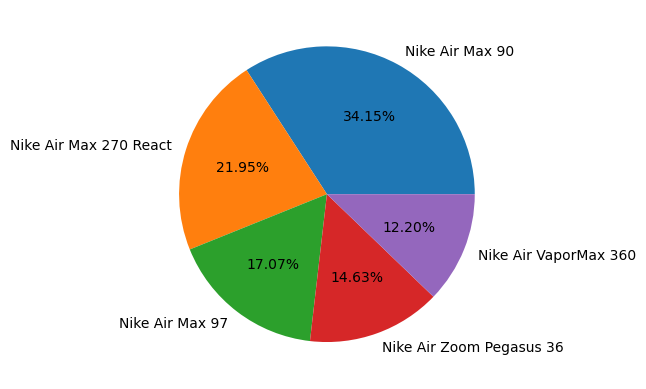

In [47]:
#top 5 products
plt.pie(productvalue[:5],labels=productnames[:5],autopct='%1.2f%%')

From the Pie Chart , We got the result of maximum shoe purchased or most popluar shoe among consumers by the customer. They are, 1.Nike Air Max 90 2.Nike Air Max 270 React 3.Nike Air Max 97 4.Nike Air Zoom Pegasus 36 5.Nike Air VaporMax 360'